In [35]:
%load_ext autoreload
%autoreload 2

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

print("pymc.version=", pm.__version__)
print("arviz.version=", az.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.17.0


# Chap1: Thinking probabilistically

# Chap 2: Programming probabilistically

# Chap 3: Modeling with linear regression

# Chap 4: Generalizing Linear Models

In [4]:
iris = pd.read_csv("iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


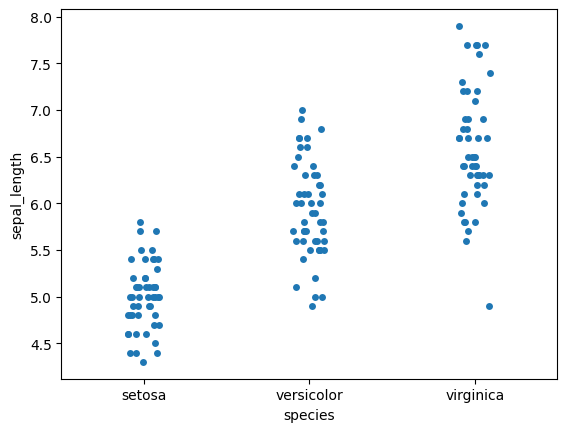

In [5]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True);
#sns.stripplot(x="species", y="sepal_length", data=iris, jitter=False, alpha=0.5);

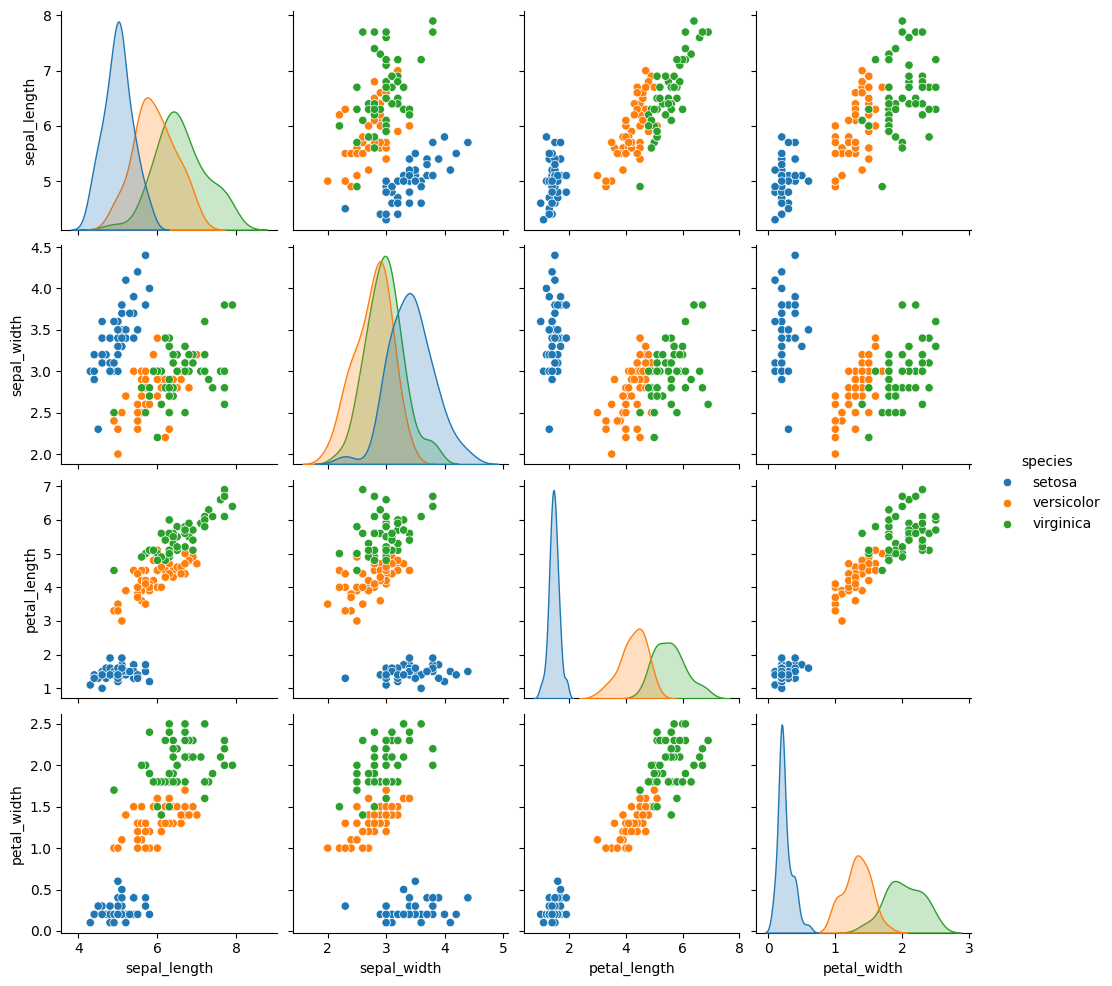

In [6]:
sns.pairplot(iris, hue="species", diag_kind="kde");

## Logistic model

In [7]:
df = iris.query("species == ('setosa', 'versicolor')")
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,versicolor
96,5.7,2.9,4.2,1.3,versicolor
97,6.2,2.9,4.3,1.3,versicolor
98,5.1,2.5,3.0,1.1,versicolor


In [8]:
y_0 = pd.Categorical(df["species"]).codes
y_0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [9]:
x_n = "sepal_length"
x_0 = df[x_n].values
print(x_0)

# Center the predictor.
x_c = x_0 - x_0.mean()

[5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
 5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
 5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5.  7.  6.4 6.9 5.5
 6.5 5.7 6.3 4.9 6.6 5.2 5.  5.9 6.  6.1 5.6 6.7 5.6 5.8 6.2 5.6 5.9 6.1
 6.3 6.1 6.4 6.6 6.8 6.7 6.  5.7 5.5 5.5 5.8 6.  5.4 6.  6.7 6.3 5.6 5.5
 5.5 6.1 5.8 5.  5.6 5.7 5.7 6.2 5.1 5.7]


In [11]:
with pm.Model() as model_0:
    # Linear regression.
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    mu = alpha + pm.math.dot(x_c, beta)
    # Logistic.
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    # Decision boundary.
    bd = pm.Deterministic('bd', -alpha / beta)
    # Model.
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)
    # Sample.
    trace_0 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [12]:
az.summary(trace_0, var_names="alpha beta".split())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.310,0.347,-0.296,0.999,0.008,0.007,1838.0,1404.0,1.0
beta,5.417,1.038,3.463,7.276,0.025,0.018,1759.0,1046.0,1.0


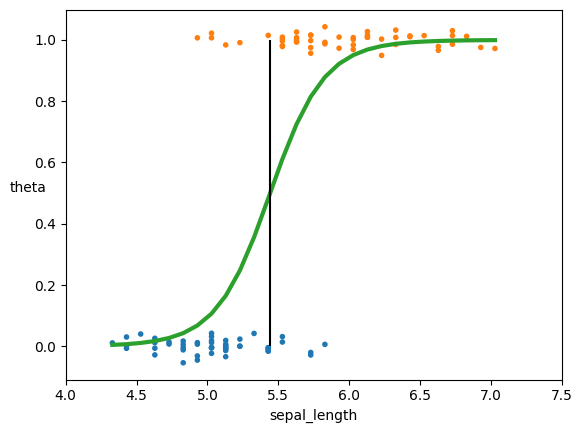

In [27]:
# Compute the mean of theta.
theta = trace_0.posterior['theta'][0].mean(axis=0)

# Plot the curve.
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)

plt.vlines(trace_0.posterior['bd'].mean(), 0, 1, color='k')
# bd_hpd = az.hpd(trace_0['bd'])
# plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
plt.scatter(x_c,
            np.random.normal(y_0, 0.02),
            marker='.',
            color=[f'C{x}' for x in y_0])
#az.plot_hpd(x_c, trace_0['theta'], color='C2')
plt.xlabel(x_n)
plt.ylabel('theta', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));

## Multiple logistic regression

In [43]:
df = iris.query("species == ('setosa', 'versicolor')")

# Dependent variable.
y_1 = pd.Categorical(df['species']).codes

# Use 2 independent variables.
x_n = ['sepal_length', 'sepal_width']
# More correlated variables.
#x_n = ['petal_width', 'petal_length']
x_1 = df[x_n].values

In [44]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    # Vector beta.
    beta = pm.Normal('beta', mu=0, sigma=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_1, beta)
    # Logistic (using the expression).
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    # Decision boundary.
    bd = pm.Deterministic('bd',
                          -alpha / beta[1] - beta[0] / beta[1] * x_1[:, 0])
    # Model.
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [39]:
az.summary(trace_1, var_names="alpha beta".split())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-8.935,4.672,-17.510,-0.281,0.121,0.086,1493.0,1575.0,1.0
beta[0],4.686,0.884,3.089,6.414,0.023,0.016,1496.0,1295.0,1.0
beta[1],-5.278,1.018,-7.250,-3.485,0.025,0.018,1641.0,1621.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


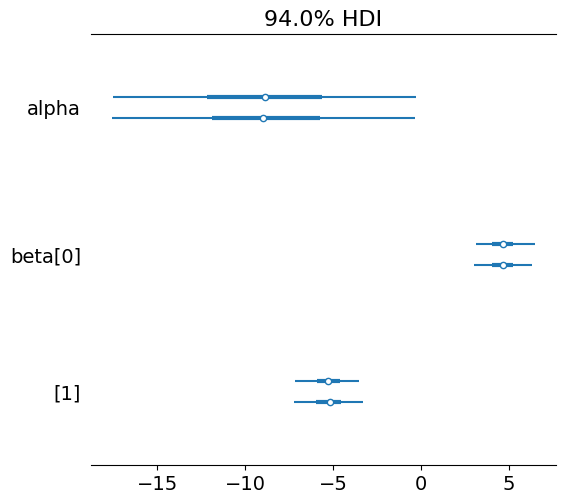

In [42]:
axes = az.plot_forest(trace_1, var_names='alpha beta'.split())

Text(0, 0.5, 'sepal_width')

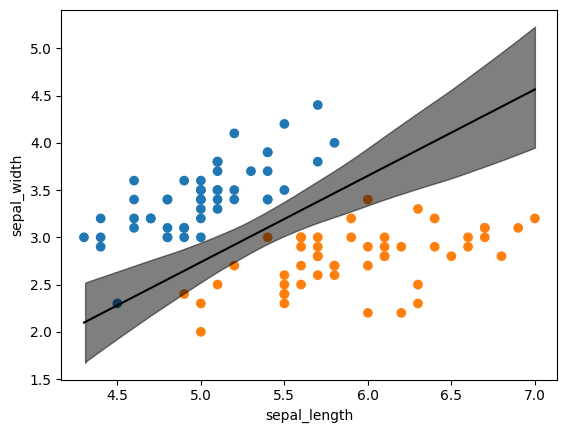

In [37]:
# Plot data.
plt.scatter(x_1[:, 0], x_1[:, 1], c=[f'C{x}' for x in y_0])

# Plot decision boundary.
idx = np.argsort(x_1[:, 0])
bd = trace_1.posterior['bd'][0].mean(axis=0)[idx]
plt.plot(x_1[:, 0][idx], bd, color='k')
# plot_hpd -> plot_hdi
az.plot_hdi(x_1[:, 0], trace_1.posterior['bd'], color='k')
#
plt.xlabel(x_n[0])
plt.ylabel(x_n[1])

## Softmax regression

In [50]:
iris = sns.load_dataset('iris')

# Dependent variables.
y_s = pd.Categorical(iris['species']).codes

# Pick the columns.
x_n = iris.columns[:-1]
print("x_n=", x_n)

# Independent variables.
x_s = iris[x_n].values
print(x_s.shape)

# Standardize.
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

x_n= Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')
(150, 4)


In [54]:
#import theano.tensor as tt

with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sigma=5, shape=3)
    beta = pm.Normal('beta', mu=0, sigma=5, shape=(4, 3))
    mu = pm.Deterministic('mu', alpha + pm.math.dot(x_s, beta))
    theta = pm.math.softmax(mu, axis=1)
    #
    yl = pm.Categorical('yl', p=theta, observed=y_s)
    trace_s = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [ ]:
# Compute the mean of quality of the model.

In [62]:
data_pred = trace_s.posterior['mu'][0].mean(axis=0)
# For each example compute mu for each output.
print(data_pred[:3])
# Compute the model.
y_pred = [np.exp(point) / np.sum(np.exp(point), axis=0) for point in data_pred]
# There is an hit when the output is equal to the highest prob.
hit_rate = np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s)
print("hit_rate=", hit_rate)

<xarray.DataArray 'mu' (mu_dim_0: 3, mu_dim_1: 3)>
array([[ 19.99993648,   6.09379561, -27.44829101],
       [ 17.0928865 ,   6.79533224, -24.76425599],
       [ 19.45496937,   5.92850583, -26.4912716 ]])
Coordinates:
    chain     int64 0
  * mu_dim_0  (mu_dim_0) int64 0 1 2
  * mu_dim_1  (mu_dim_1) int64 0 1 2
hit_rate= 0.98


/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


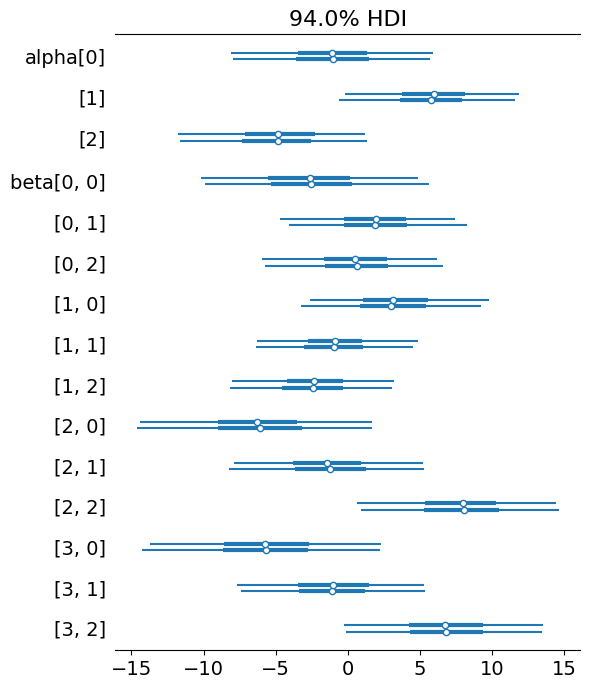

In [65]:
axes = az.plot_forest(trace_s, var_names='alpha beta'.split())

In [66]:
#az.summary(trace_s, var_names="alpha beta".split())

In [ ]:
# Comments
# - The model looks really good but it's all in sample (we need some OOS)
# - The uncertainty of each param is very large
#   - The problem is that the probability needs to sum to 1 so there is freedom in the model.

In [70]:
with pm.Model() as model_sf:
    # Add a 0 to the parameters.
    alpha = pm.Normal('alpha', mu=0, sigma=2, shape=2)
    beta = pm.Normal('beta', mu=0, sigma=2, shape=(4, 2))
    alpha_f = pm.math.concatenate([[0], alpha])
    beta_f = pm.math.concatenate([np.zeros((4, 1)), beta], axis=1)
    
    # Dot product.
    mu = alpha_f + pm.math.dot(x_s, beta_f)
    
    # Compute model.
    theta = pm.math.softmax(mu, axis=1)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    trace_sf = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


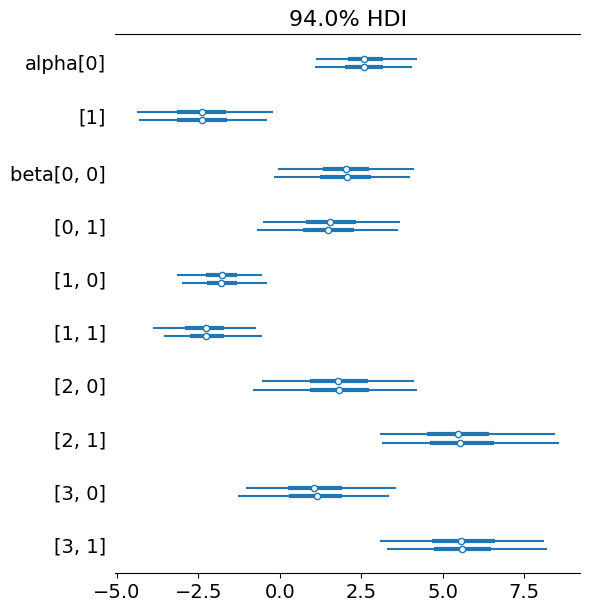

In [71]:
axes = az.plot_forest(trace_sf, var_names='alpha beta'.split())